## Global Macro Dashboard

An overview of some important indicators of the global economy's health.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import quandl

import pandas_datareader.data as web
import datetime
import missingno as msno

from IPython.core.display import HTML

%matplotlib inline
plt.close('all')

### US Treasury bond yields

#### Load data US treasury bond yields

In [2]:
# load from Quandl API
US_treasury_yields = quandl.get("USTREASURY/YIELD", authtoken="e4FyZJfz6ukboUWG4Pm_")
# save a copy locally as a CSV
US_treasury_yields.to_csv("data/US_treasury_yields.csv")

#### Load US data on GDP, inflation etc from FRED

In [3]:
US_GDP = web.DataReader('GDP', 'fred')
US_GDP.to_csv("data/US_GDP.csv")
US_inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred')
US_inflation.to_csv("data/US_inflation.csv")

# FRED also has Treasury yield data available, but there seem to be more missing
# values compared to quandl, so using Quandl as above
# UST_3m_FRED = web.DataReader(['T10Y3MM'], 'fred', start, end)
# UST_2y_FRED = web.DataReader(['T10Y2Y'], 'fred', start, end)

In [4]:
display(HTML(US_treasury_yields.tail(10).to_html()))

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2019-02-28,2.44,2.47,2.45,2.50,2.54,2.52,2.50,2.52,2.63,2.73,2.94,3.09
2019-03-01,2.44,2.46,2.44,2.52,2.55,2.55,2.54,2.56,2.67,2.76,2.97,3.13
2019-03-04,2.45,2.46,2.46,2.54,2.54,2.55,2.52,2.53,2.63,2.72,2.93,3.09
2019-03-05,2.44,2.45,2.46,2.53,2.54,2.55,2.52,2.53,2.63,2.72,2.93,3.08
2019-03-06,2.43,2.44,2.47,2.53,2.54,2.52,2.49,2.49,2.59,2.69,2.90,3.06
2019-03-07,2.45,2.46,2.45,2.52,2.52,2.47,2.44,2.44,2.54,2.64,2.86,3.03
2019-03-08,2.45,2.46,2.46,2.52,2.53,2.45,2.43,2.42,2.51,2.62,2.83,3.00
2019-03-11,2.44,2.45,2.46,2.54,2.53,2.47,2.45,2.44,2.53,2.64,2.86,3.03
2019-03-12,2.44,2.46,2.46,2.53,2.52,2.45,2.41,2.41,2.50,2.61,2.82,3.00


#### Checking for missing values

In [ ]:
#msno.bar(US_treasury_yields.sample(7295), figsize=(8, 4))
#plt.show()

#### Visualising US Treasury yields for different tenors 

In [ ]:
# set now to current time and date
now = datetime.datetime.now()
# set a start date in the past
start = datetime.datetime(2008, 1, 1)
# other start/end options: 
# start = '20080101'
# end = ''
today = datetime.datetime(now.year, now.month, now.day)

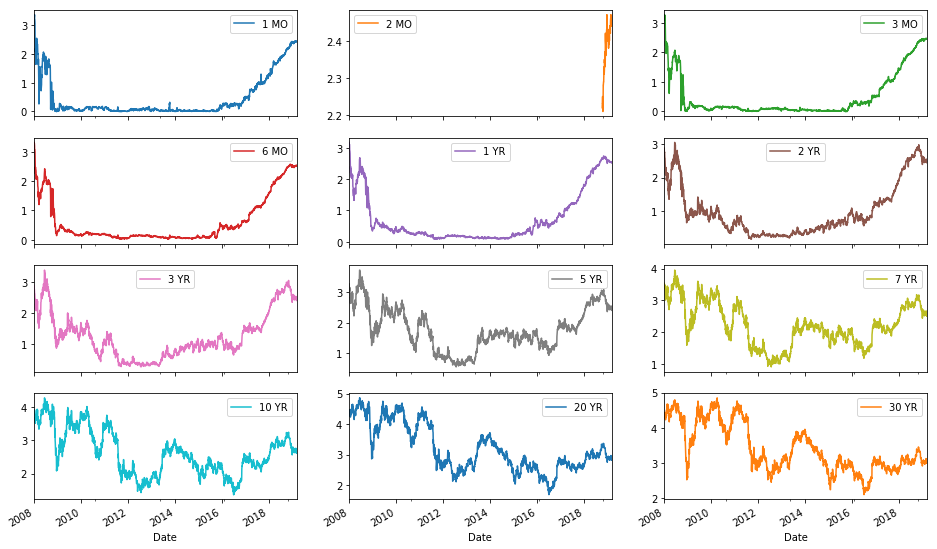

In [ ]:
US_treasury_yields.loc[start:].plot(subplots=True, layout=(4,3), figsize=(16, 10))
plt.show();

#### US Treasury yield curves 

In [ ]:
TSY3m2y =  US_treasury_yields['2 YR'] - US_treasury_yields['3 MO']
TSY2y10y = US_treasury_yields['10 YR'] - US_treasury_yields['2 YR']

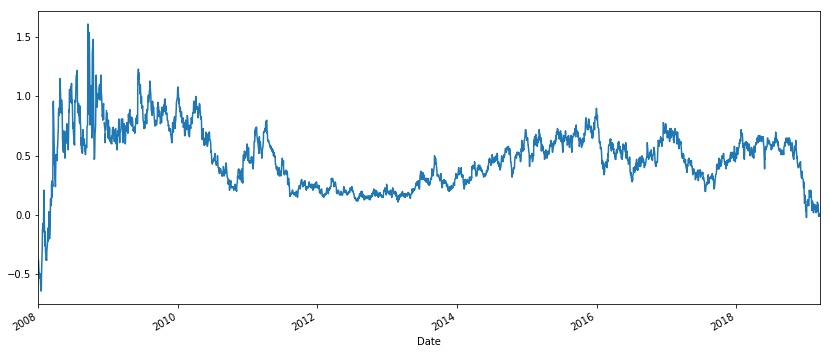

In [ ]:
TSY3m2y.loc[start:].plot(figsize=(14, 6))
plt.show();

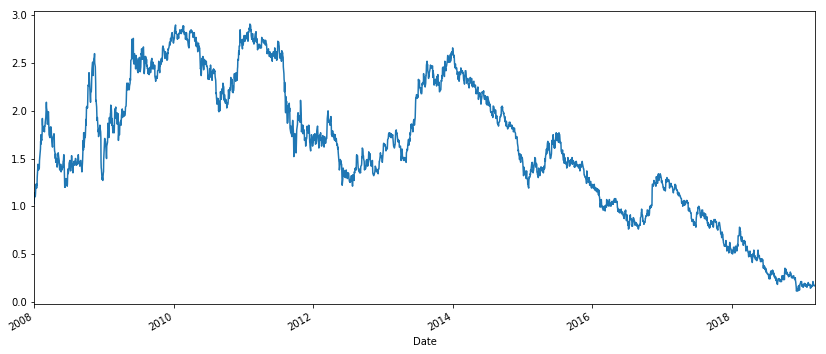

In [ ]:
TSY2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

## Germany bond yields and curves

### Data sources

#### Create list of bond tenors

In [ ]:
tenor = ['6 MO', '1 YR', '2 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']

#### Import data from Bundesbank website

In [ ]:
# creates dictionary where keys represent bond tenors and values are the URL of corresponding dataset
DE = {"DE6 MO_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3210&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE1 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3211&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE2 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3213&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE5 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3219&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE7 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3223&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE10 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3229&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE20 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3449&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE30 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3500&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to="}

In [ ]:
DE.keys()
# The Bundesbank's data source URLs are extremely long and for the sake of uncluttered presentation hidden

dict_keys(['DE6 MO_input', 'DE1 YR_input', 'DE2 YR_input', 'DE5 YR_input', 'DE7 YR_input', 'DE10 YR_input', 'DE20 YR_input', 'DE30 YR_input'])

### Functions for loading, cleaning and concatenating data

In [ ]:
def instrument_names(tenors):
    """
    creates variable names for each instrument, e.g. "DE2y" for a
    2yr German bond and also input variables that will be used in
    subsequent cleaning functions, e.g. DE2y_input
    """
    input_names = [0] * len(tenors)
    
    for i in tenors:
        index = tenors.index(i)
        if index < len(tenors):
            tenors[index] = 'DE'+ i
            input_names[index] = tenors[index] + '_input'
            
    return tenors, input_names

def bunds_clean(URL, tenor):
    """
    Loads and transforms very poorly formatted CSV files with data for each
    bond tenor from German Bundesbank and returns cleaned pandas dataframe
    """
    DF = pd.read_csv(URL, sep=';') 
    
    assert type(tenor) == str, "Tenor needs to be a string"   
    
    # remove rows without relevant data
    # the first four rows of all files need to be removed 
    # the last row needs to be removed in some files:
    # - tenors 20 YR and 30 YR are fine - hence DF[4:] below
    # - tenors up to 10 YR contain a comment in the last row,
    #   which needs to be removed, hence DF[4:-1] for all of those
    last_row = DF[-1:].to_string()
    if "Bemerkung" in last_row:
        DF = DF[4:-1]
    else:
        DF = DF[4:]  
        
    # rename columns to give meaningful name
    new_columns = DF.columns.values
    new_columns[0] = 'DATE'
    new_columns[1] = tenor 
    DF.columns = new_columns 
    
    # assign last column to variable 'dropcolumn'
    dropcolumn = DF.columns[2]
    
    # use dropcolumn to remove rows that have missing values (indicated by string in German instead of NaN)
    DF = DF[DF[dropcolumn] != 'Kein Wert vorhanden']
    
    # now remove last column 
    DF = DF.drop([dropcolumn], axis=1)
    
    # reset dataframe index to 0 - was not the case because we removed rows earlier
    DF.reset_index(drop=True, inplace=True)
    
    # replace German comma (,) with dot in RATE column
    DF[tenor] = [x.replace(',', '.') for x in DF[tenor]]
    
    # convert RATE column values from string to float
    DF[tenor] = DF[tenor].astype('float')
    
    # convert DATE column values from string to datetime
    DF['DATE'] = pd.to_datetime(DF['DATE'])
    
    # replace dataframe index column with DATE column
    DF.set_index(['DATE'], drop=True, inplace=True)
    
    return DF

def clean_and_join(input_name, tenor):
    """
    Calls bunds_clean function for each input file and concatenates 
    cleaned output into one pandas dataframe, which is returned
    """
    combined = pd.DataFrame() 
    
    for i in range(len(tenor)):
        result = bunds_clean(DE[input_name[i]], tenor[i])
        combined = pd.concat([combined, result], axis=1)
        
    return combined

In [ ]:
results = instrument_names(tenor[:])
instruments = results[0]
input_name = results[1]

DE_bond_yields = clean_and_join(input_name, tenor)

DE_bond_yields.to_csv("data/DE_bond_yields.csv")

In [ ]:
display(HTML(DE_bond_yields.tail(5).to_html()))

#### Checking for missing data

In [ ]:
#msno.bar(DE_bond_yields.sample(5473), figsize=(8, 3))
#plt.show()

#### Visualising German bond yields for different tenors 

In [ ]:
start = '20080101'
end = today
DE_bond_yields.loc[start:].plot(subplots=True, layout=(4,2), figsize=(16, 10))
plt.show();

#### German yield curves

In [ ]:
DE2y10y = DE_bond_yields['10 YR'] - DE_bond_yields['2 YR']

In [ ]:
DE2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

In [ ]:
DE_curve_today = DE_bond_yields.iloc[-1:]
DE_curve_month_ago = DE_bond_yields.iloc[-21:-20]
DE_curve_3month_ago = DE_bond_yields.iloc[-63:-62]
DE_curve_6month_ago = DE_bond_yields.iloc[-126:-125]
DE_curve_year_ago = DE_bond_yields.iloc[-252:-251]

DE_curves_combined = pd.concat([DE_curve_month_ago, DE_curve_today, DE_curve_3month_ago, DE_curve_6month_ago, DE_curve_year_ago])
DE_curves_combined

In [ ]:
DE_diff_today_month_ago = DE_curves_combined.iloc[1] - DE_curves_combined.iloc[0]
DE_diff_today_3month_ago = DE_curves_combined.iloc[2] - DE_curves_combined.iloc[0]
DE_diffs_combined = pd.concat([DE_diff_today_month_ago, DE_diff_today_3month_ago])
DE_diffs_combined

## Work in progress

## Australian yields

In [ ]:
# URL_OZ = "https://www.rba.gov.au/statistics/tables/csv/f2-data.csv?v=2019-03-08-18-27-13"
#OZ = pd.read_csv(URL_OZ) 
# get 
#data = pd.read_csv(URL_OZ) 
#OZ.tail()

#test = pd.read_csv("data/f1-data.csv", skiprows=8)
#test.head()



## Russian yields

In [ ]:
# needs scraping

#https://www.cbr.ru/eng/hd_base/zcyc_params/

## Canada

In [ ]:
# . "https://www.bankofcanada.ca/valet/observations/FXCADUSD/csv"
# with Get?


## Japan

In [ ]:
# load long-term history and most recent data points 
japan_hist = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/historical/jgbcme_all.csv", header=1)
japan_current = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/jgbcme.csv", header=1)

In [ ]:
# convert date format from separator "/" to "-"
japan_hist["Date"] = pd.to_datetime(japan_hist["Date"]).dt.strftime('%Y-%m-%d')
japan_current["Date"] = pd.to_datetime(japan_current["Date"]).dt.strftime('%Y-%m-%d')

In [ ]:
# convert those columns in japan_hist that are objects to floats
for col in japan_hist.columns[1:]:
    japan_hist[col] = pd.to_numeric(japan_hist[col], errors='coerce')

In [ ]:
# replace index column with date column
japan_hist.set_index(['Date'], drop=True, inplace=True)
japan_current.set_index(['Date'], drop=True, inplace=True)

In [ ]:
combined_JGB = pd.concat([japan_hist, japan_current])

In [ ]:
# save a copy locally as a CSV
combined_JGB.to_csv("data/JGB_yields.csv")

In [ ]:
combined_JGB.tail(10)

In [ ]:
start = '2010-01-01'
end = today
combined_JGB[start:].plot(subplots=True, layout=(8,2), figsize=(16, 25))
plt.show();

#### Todo

In [ ]:
# Write function for DE yield curves

#def generate_yieldcurves:

#DE_yield_curve = pd.DataFrame()
#DE_yield_curve['2y10y'] =  DE_bond_yields.apply(lambda x: x['10y'] - x['2y'], axis=1)

#def clean_and_join(input_name, tenor):
#    """
#    """
#    combined = pd.DataFrame() 
#    for i in range(len(tenor)):
#        result = bunds_clean(DE[input_name[i]], tenor[i])
#        combined = pd.concat([combined, result], axis=1)
#    return combined